In [1]:
import pandas 
import pylab
from pandas import *
from pylab import *
import os

In [15]:
import pandas 
import random


def readflink(filename,df):
    csv= read_csv(filename,names = ["system","windowsize","batchfilesize"
                                    ,"workload","latency","throughput","numberelements"])
    return concat([df,csv]).reset_index()
def readFileSpark(filename):
    csv= read_csv(filename,names = ["system","windowsize","batchfilesize"
                                    ,"workload","latency","throughput","numberelements"])
    if (len(csv.index)==1):
        #print(csv)
        return csv
    else:
        d = {'system' : ["spark"],
        'windowsize' : [csv.ix[0,[1]][0]],
        'batchfilesize' : [csv.ix[0,[2]][0]],
        'workload' : [csv.ix[0,[3]][0]],
        'latency' : [getMeanLatency(csv)],
        'throughput' : [getAvgThroughput(csv)],
        'numberelements' : [getSumElements(csv)]         
            }
        csv=DataFrame(d,columns=["system","windowsize","batchfilesize"
                                    ,"workload","latency","throughput","numberelements"])
        #print(csv)    
        return csv
def getAvgThroughput(file):
    th=file.ix[1:len(file)-2,[5]]
    #print("ddd",th)
    #print(th[0])
    return th.mean()[0]
def getMeanLatency(file):
    lat=file.ix[1:len(file)-2,[4]]
    l=len(lat)
    m=lat[int(round(0.5*l)):l].mean()[0]
    return round(m,1)
def getSumElements(file):
    nums=file.ix[1:len(file)-2,[6]]
    return nums.sum()[0]
def getAvgElements(file):
    nums=file.ix[30:len(file)-2,[3]]
    return nums.mean()[0]
def getBatch(name):
    out=""
    for l in name:
        if(l=="-"):
            b=False
            return int(out)
        if(l=="c"):
            return 1000
        out+=str(l)
    return int(out)

def getTupleSpark(file,path):
    parts=path.split("\\")
    return(parts[1],int(parts[2]),int(parts[3]),int(parts[4]),getMeanLatency(file),getAvgThroughput(file),(len(file)-2) )
    #return (parts[1],int(parts[2]),int(parts[3]),int(parts[4]),
            #int(getMeanLatency(file)),getSumElements(file),getAvgElements(file),getBatch(parts[5]))
def getTupleFlink(file,path):
    parts=path.split("\\")
    return (parts[1],int(parts[2]),int(parts[3]),int(parts[4])
            ,int(getMeanLatency(file)),getSumElements(file),getAvgElements(file),0)
def mergeDuplicates(num,df,merges=0):
    #print(num)
    #print(df)
    sys="system"
    win="windowsize"
    sli="batchfilesize"
    wor="workload"
    lat="latency"
    ele="numberelements"
    avgE="throughput" 
    #avgE="avgElements"
    end=0
    found=False
    #print(df.iloc[0][sys])
    if(num==len(df)-2):
        return df
    for i in range (num,len(df)-1):
        
        if( (df.iloc[i][sys]==df.iloc[i+1][sys]) and (df.iloc[i][win]==df.iloc[i+1][win]) ):
            if( (df.iloc[i][sli]==df.iloc[i+1][sli]) and (df.iloc[i][wor]==df.iloc[i+1][wor]) ):
                if( (df.iloc[i][bat]==df.iloc[i+1][bat]) ):
                    sums=(df.iloc[i][ele]+df.iloc[i+1][ele])
                    avg= (df.iloc[i][lat]*df.iloc[i][ele]+df.iloc[i+1][lat]*df.iloc[i+1][ele])/sums
                    avgele=(df.iloc[i][avgE]*df.iloc[i][ele]+df.iloc[i+1][avgE]*df.iloc[i+1][ele])/sums
                    #print(num,i,sums,avg,df.iloc[i])
                    df=df.set_value(i+merges,lat,avg)
                    df=df.set_value(i+merges,avgE,avgele)
                    #print(df.iloc[i])
                    end=i
                    found=True
                    #df.index[i][lat]=avg
                    #df.index[i][ele]=sums
                    break;
                    #df=df.drop(df.index[[i+1]])
                    #print(avg,sums)
                    #print("------")
        #print(df[1])
     
    
    if (found):
        return mergeDuplicates( end,df.drop(df.index[[end+1]]),merges+1 )
    else:
        return df
    
    
def ignoreLowWorkload(delta,df):
    return df.loc[df.loc[:,"workload"]>=delta]

def ignoreLowThroughput(delta,df):
    return df.loc[df.loc[:,"throughput"]>=delta]
    #print(df.loc[:,"workload"]>delta)

def makeitrandom(df,xname):
    for i in range(0,len(df)):
        ran=random.randint(1, 10)*0.03+1.5
        old=df.ix[i][xname]
        #print(old,ran,old*ran)
        df.set_value(i, xname, ran*old)
    return df

df=getResults()
#df=makeitrandom(df,"batchfilesize")
#df
#df=mergeDuplicates(0,df)
#df=ignoreLowWorkload(500,df)
#df=ignoreLowThroughput(1,df)
#df
#df.drop(df.index[[1,3]])
#df[0:10]
#iris.drop(iris.index[[1,3,5,7]])
#(readFileFlink("andresdata.txt"))

#file=open("andresdata.txt")
#print(file)
df=readflink(open("andresdata.txt"),df)
df

,level_0,batchfilesize,index,latency,numberelements,system,throughput,windowsize,workload
0,0,1000,0.0,395.1,85,spark,2.0,1000,5
1,1,1000,0.0,323.4,108,spark,3.0,1000,5
2,2,1000,0.0,423.6,126,spark,4.0,1000,7
3,3,10000,0.0,565.0,2780,spark,10.0,1000,10
4,4,10000,0.0,508.0,7070,spark,0.0,1000,100
5,5,10000,0.0,521.0,20176,spark,97.0,1000,100
6,6,10000,0.0,773.0,131200,spark,0.0,1000,1000
7,7,10000,0.0,354.0,213528,spark,970.0,1000,1000
8,8,10000,0.0,1128.0,228980,spark,0.0,1000,10000
9,9,10000,0.0,1429.0,40283,spark,0.0,1000,10000


In [7]:
#find all results
import glob, os
#os.chdir("/results")
def getResults():
    
    flink=True
    data=list()
    #df = DataFrame(data,columns=index)   
    index=["system","windowSize","batchfilesize","workload","latency","throughput","numberElements"]


    for sysDir in glob.glob("results\*"):
        for windowTime in glob.glob(sysDir+"\*"):
            for slidingTime in glob.glob(windowTime+"\*"):
                for workload in glob.glob(slidingTime+"\*"):
                    for files in glob.glob(workload+"\*"):
                        #print(files)
                        found=False
                        #if(flink):
                            #if (os.path.getsize(files)>0):
                                #file=readFileFlink(files)
                                #t=getTupleFlink(file,files)
                                #found=True
                                #print(file,"/n",files)
                        #else:
                        if (os.path.getsize(files)>0):
                            #print(files)
                            t=readFileSpark(files)
                            #print(t)
                            #t=getTupleSpark(file,files)
                                #print(files)
                                #if(files=="results\spark\5000\1000\300000\1000-1484517606000.csv"):
                                    #print(files)
                                    #print(file)
                                    #print(t)
                            found=True
                        if(found):      
                            data.append(t)
    #print("dadadaadadad")                            
    #df = DataFrame(data,columns=index) 
    
    #df.append(Series(t[0:7],index=index),ignore_index=True) 
    df=concat(data)
    df=df.reset_index()
    #df=df.fillna(0, inplace=True)
    return df
df=getResults()
#df
#resS=df.loc[df["system"]=="flink"].loc[df["windowSize"]==3000].loc[df["slidingSize"]==2000]
#resS
#df=mergeDuplicates(0,df)
df

,index,system,windowsize,batchfilesize,workload,latency,throughput,numberelements
0,0,spark,1000,1000,5,395.1,2.0,85
1,0,spark,1000,1000,5,323.4,3.0,108
2,0,spark,1000,1000,7,423.6,4.0,126
3,0,spark,1000,10000,10,565.0,10.0,2780
4,0,spark,1000,10000,100,508.0,0.0,7070
5,0,spark,1000,10000,100,521.0,97.0,20176
6,0,spark,1000,10000,1000,773.0,0.0,131200
7,0,spark,1000,10000,1000,354.0,970.0,213528
8,0,spark,1000,10000,10000,1128.0,0.0,228980
9,0,spark,1000,10000,10000,1429.0,0.0,40283


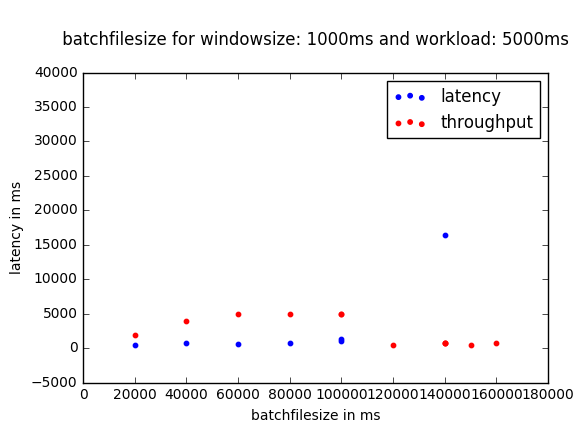

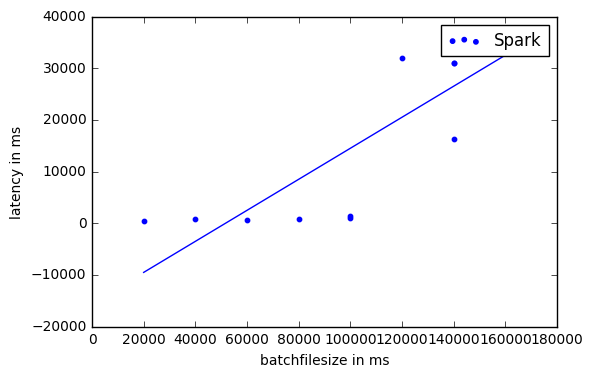

In [4]:
#analysis
#import seaborn
#import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

    
def plotLatencyTh(varName2,var2,varName3,var3,xName,yName,y2Name,save):
    spark=True
    flink=False
     #make plot without regression line
    if(spark):
        resS=df.loc[df["system"]=="spark"]
        resS=resS.loc[df[varName2]==var2]
        resS=resS.loc[df[varName3]==var3]
        xS=resS[xName].values
        yS=resS[yName].values
        yS2=resS[y2Name].values
        if(varName3=="workload"):
            if(y2Name=="throughput"):
                for i in range(0,len(yS2)):
                    #print(xS[i],yS[i])
                    if(yS2[i]>var3):
                        yS2[i]=var3
                        #print(yS[i])
        
        plt.scatter( xS , yS ,color="Blue",s=10,label=yName)
        plt.scatter( xS , yS2 ,color="Red",s=10,label=y2Name)
    if(flink):
        resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3]    
        xF=resF[xName].values
        yF=resF[yName].values
        plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
    
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    titleString="\n "+xName+" for "+varName2+": "+str(var2)+"ms and "+varName3+": "+str(var3)+"ms \n "
    xunit=" in ms"
    yunit=" in ms"
    #plt.ylim([0,3000])
    #plt.title(titleString)
    plt.xlabel(xName+xunit)
    plt.ylabel(yName+yunit)
    plt.legend()
    plt.title(titleString)
    path='graphs/%s%s%s%s.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()
    
    #make plot with regression line
    if(spark):
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
        plt.plot(np.unique(xS), np.poly1d(np.polyfit(xS, yS, 1))(np.unique(xS)),color="Blue")
    if(flink):
        plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
        plt.plot(np.unique(xF), np.poly1d(np.polyfit(xF, yF, 1))(np.unique(xF)),color="Red")
    
    #plt.ylim([0,10000])
    #plt.title(titleString)
    plt.xlabel(xName+xunit)
    plt.ylabel(yName+yunit)
    plt.legend()
    
    path='graphs/%s%s%s%s_With.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()   
    

sys="system"

win="windowsize"
bat="batchfilesize"
wor="workload"

lat="latency"
ele="numberelements"
th="throughput"


df=getResults()

df=ignoreLowThroughput(1,df)

#df=mergeDuplicates(0,df)



#plotLatencyTh(win,1000,wor,1000,bat,lat,th,False)

plotLatencyTh(win,1000,wor,5000,bat,lat,th,False)


#plotLatencyTh(win,1000,bat,100000,bat,lat,th,False)

#plotLatencyTh(win,1000,bat,100000,wor,lat,th,False)


#plotLatency2(win,1000,bat,10000,wor,lat,False)

#plotLatency2(wor,1000,bat,10000,win,lat,False)

#plotLatency2(win,1000,bat,10000,wor,th,False)

#plotLatency2(win,1000,wor,1000,bat,th,False)

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


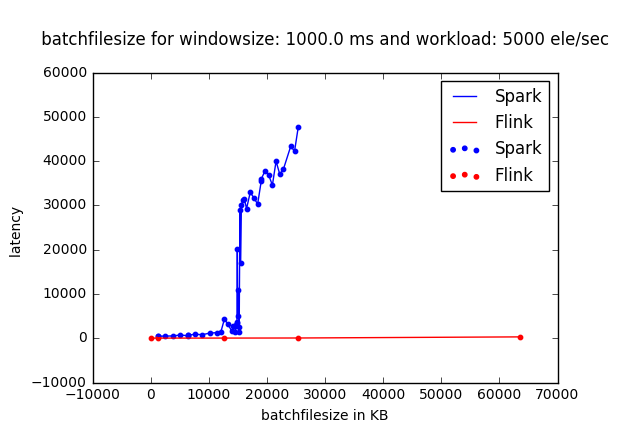

In [22]:
#analysis
#import seaborn
#import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def plotLatency(varName2,var2,varName3,var3,xName,yName):
    
    resS=df.loc[df["system"]=="spark"].loc[df[varName2]==var2].loc[df[varName3]==var3]
    #resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3]
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    
    olsS=sm.ols(formula="latency ~ %s"%xName, data=resS).fit()
    print(olsS.params[0],olsS.params[1])
    ax=resS.plot.scatter(x=xName,y=yName,label="Spark",color="Blue")
    #resF.plot.scatter(x=xName,y=yName,label="Flink",ax=ax,color="Red",title=titleString)
    path='graphs/%s%s%s%s.png' %(varName2,var2,varName3,var3)
    #savefig(path)
    
def plotLatency2(varName2,var2,varName3,var3,xName,yName,save):
    fig = plt.figure()
    spark=True
    flink=True
     #make plot without regression line
    if(spark):
        resS=df.loc[df["system"]=="spark"]
        resS=resS.loc[df[varName2]==var2].sort([xName])   
        resS=resS.loc[df[varName3]==var3]
        xS=resS[xName].values*130/1024
        yS=resS[yName].values
        
        if(varName3=="workload"):
            if(yName=="throughput"):
                for i in range(0,len(yS)):
                    #print(xS[i],yS[i])
                    if(yS[i]>var3):
                        yS[i]=var3
                        #print(yS[i])
        #x=np.arange(0,len(y))
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
        plt.plot( xS , yS ,color="Blue",label="Spark")
    if(flink):
        resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3]    
        xF=resF[xName].values*130/1024
        yF=resF[yName].values
        plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
        plt.plot( xF , yF ,color="Red",label="Flink")
    
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    titleString="\n "+xName+" for "+varName2+": "+str(var2*1/1)+" ms and "+varName3+": "+str(var3)+" ele/sec \n "
    xunit=" in KB"
    yunit="  "
    #plt.ylim([0,3000])
    #plt.title(titleString)
    plt.xlabel(xName+xunit)
    plt.ylabel(yName+yunit)
    plt.legend()
    plt.title(titleString)
    path='graphs/%s%s%s%s%s.png' %(varName2,var2,varName3,var3,yName)
    
    if(save):
        fig.savefig(path,dpi=fig.dpi,bbox_inches='tight')   
    plt.show()
    
    #make plot with regression line
    #if(spark):
    #    plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
    #    plt.plot(np.unique(xS), np.poly1d(np.polyfit(xS, yS, 1))(np.unique(xS)),color="Blue")
    #if(flink):
    #    plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
    #    plt.plot(np.unique(xF), np.poly1d(np.polyfit(xF, yF, 1))(np.unique(xF)),color="Red")
    
    #plt.ylim([0,10000])
    #plt.title(titleString)
    #plt.xlabel(xName+xunit)
    #plt.ylabel(yName+yunit)
    #plt.legend()
    
    #path='graphs/%s%s%s%s%s_With.png' %(varName2,var2,varName3,var3,yName)
    
    #if(save):
        #savefig(path)   
    #plt.show()   
    

sys="system"

win="windowsize"
bat="batchfilesize"
wor="workload"

lat="latency"
ele="numberelements"
th="throughput"


df=getResults()


#df=makeitrandom(df,bat)
df=ignoreLowThroughput(1,df)
#df=mergeDuplicates(0,df)

df=readflink(open("andresdata.txt"),df)

#plotLatency2(bat,100000,win,1000,wor,lat,True)

#plotLatency2(bat,100000,win,1000,wor,th,False)



#plotLatency2(win,1000,bat,10000,wor,lat,True)

#plotLatency2(win,1000,bat,10000,wor,th,True)

#plotLatency2(win,1000,wor,1000,bat,lat,True)

#plotLatency2(win,1000,wor,1000,bat,th,True)


plotLatency2(win,1000,wor,5000,bat,lat,True)

#plotLatency2(win,1000,wor,5000,bat,th,True)

#plotLatency2(bat,50000,wor,5000,win,lat,True)

#plotLatency2(wor,5000,bat,50000,win,th,True)





In [6]:
def plotElementsRatio(varName2,var2,varName3,var3,xName,yName,save):
    spark=True
    flink=True
     #make plot without regression line
    if(spark):
        resS=df.loc[df["system"]=="spark"].loc[df[varName2]==var2].loc[df[varName3]==var3].sort([xName])
        
        xS=resS[xName].values
        factorS=resS["workload"].values*resS["windowSize"].values/9000.0
        
        yS=resS[yName].values/factorS
        plt.ylim([0,0.5])
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
        plt.plot( xS , yS ,color="Blue")
    if(flink):
        resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3].sort([xName])   
        xF=resF[xName].values
        factorF=resF["workload"].values*resF["windowSize"].values/9000.0
        yF=resF[yName].values/factorF
        
        plt.plot( xF , yF ,color="Red",label="Flink")
        plt.scatter( xF , yF ,color="Red",s=10)
    
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    titleString="Workload for window length = 3s and sliding length = 2s"
    titleString="\n "+xName+" for "+varName2+": "+str(var2)+"ms and "+varName3+": "+str(var3)+"ms \n "
    xunit=" in ms"
    #plt.ylim([0,3000])
    #plt.title(titleString)
    plt.ylim([0,0.5])
    plt.xlabel(xName+xunit)
    plt.ylabel("percentage of processed elements")
    plt.legend()
    
    path='graphs/%s%s%s%selements.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()
    
    #make plot with regression line
    sc=1
    if(spark):
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
        plt.plot(np.unique(xS[sc:]), np.poly1d(np.polyfit(xS[sc:], yS[sc:], 1))(np.unique(xS[sc:])),color="Blue")
    if(flink):
        plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
        plt.plot(np.unique(xF), np.poly1d(np.polyfit(xF, yF, 1))(np.unique(xF)),color="Red")
    
    #plt.ylim([0,10000])
    #plt.title(titleString)
    plt.xlabel(xName+xunit)
    plt.ylabel("percentage of processed elements")
    plt.legend()
    
    path='graphs/%s%s%s%selements_With.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()   
    
    
sys="system"
win="windowSize"
sli="slidingSize"
wor="workload"
lat="latency"
ele="num elements"
avg="avgElements"
df=getResults()

df=mergeDuplicates(0,df)

#df=ignoreLowWorkload(50000,df)

plotElementsRatio(win,3000,sli,2000,wor,avg,False)

plotElementsRatio(sli,1000,wor,100000,win,avg,False)

plotElementsRatio(win,30000,wor,100000,sli,avg,False)


KeyError: 'windowSize'

In [ ]:
def plotElements(varName2,var2,varName3,var3,xName,yName,save):
    spark=True
    flink=True
     #make plot without regression line
    if(spark):
        resS=df.loc[df["system"]=="spark"].loc[df[varName2]==var2].loc[df[varName3]==var3].sort([xName])
        
        xS=resS[xName].values
        yS=resS[yName].values
        
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
        plt.plot( xS , yS ,color="Blue")
    if(flink):
        resF=df.loc[df["system"]=="flink"].loc[df[varName2]==var2].loc[df[varName3]==var3].sort([xName])   
        xF=resF[xName].values
        yF=resF[yName].values
        
        plt.plot( xF , yF ,color="Red",label="Flink")
        plt.scatter( xF , yF ,color="Red",s=10)
    
    titleString=varName2+": "+str(var2)+" ; "+varName3+": "+str(var3)
    titleString="\n "+xName+" for "+varName2+": "+str(var2)+"ms and "+varName3+": "+str(var3)+"ms \n "
    xunit=" in ms"
    #plt.ylim([0,3000])
    #plt.title(titleString)
    plt.xlabel(xName+xunit)
    plt.ylabel("Avg. number of elementsin window")
    plt.legend()
    
    path='graphs/%s%s%s%seleratio.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()
    
    #make plot with regression line
    if(spark):
        plt.scatter( xS , yS ,color="Blue",s=10,label="Spark")
        plt.plot(np.unique(xS), np.poly1d(np.polyfit(xS, yS, 1))(np.unique(xS)),color="Blue")
    if(flink):
        plt.scatter( xF , yF ,color="Red",s=10,label="Flink")
        plt.plot(np.unique(xF), np.poly1d(np.polyfit(xF, yF, 1))(np.unique(xF)),color="Red")
    
    #plt.ylim([0,10000])
    #plt.title(titleString)
    plt.xlabel(xName+xunit)
    plt.ylabel("Avg. number of elementsin window")
    plt.legend()
    
    path='graphs/%s%s%s%seleratio_With.png' %(varName2,var2,varName3,var3)
    
    if(save):
        savefig(path)   
    plt.show()   
    
    
sys="system"
win="windowSize"
sli="slidingSize"
wor="workload"
lat="latency"
ele="num elements"
avg="avgElements"
df=getResults()

df=mergeDuplicates(0,df)

#df=ignoreLowWorkload(50000,df)

plotElements(win,3000,sli,2000,wor,avg,False)

plotElements(sli,1000,wor,100000,win,avg,False)

plotElements(win,30000,wor,100000,sli,avg,False)


In [ ]:
df=getResults()
df=mergeDuplicates(0,df)

plotLatency2(sli,1000,wor,300000,win,lat,True)
plotElements(sli,1000,wor,300000,win,avg,True)
plotElementsRatio(sli,1000,wor,300000,win,avg,True)

In [ ]:
df=getResults()
df=mergeDuplicates(0,df)

plotLatency2(win,30000,wor,300000,sli,lat,True)
plotElements(win,30000,wor,300000,sli,avg,True)
plotElementsRatio(win,30000,wor,300000,sli,avg,True)

In [ ]:
df=getResults()
df=mergeDuplicates(0,df)

plotLatency2(win,3000,sli,2000,wor,lat,True)
plotElements(win,3000,sli,2000,wor,avg,True)
plotElementsRatio(win,3000,sli,2000,wor,avg,True)

results-examples\10000-180.csv


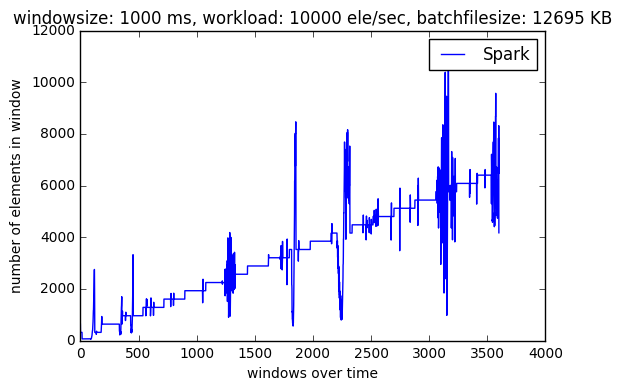

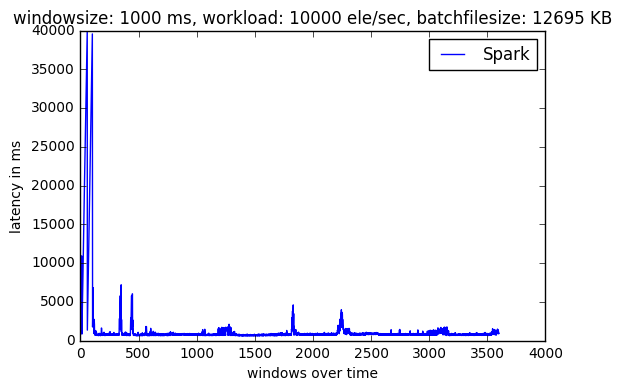

776.002
results-examples\120-20-3min.csv


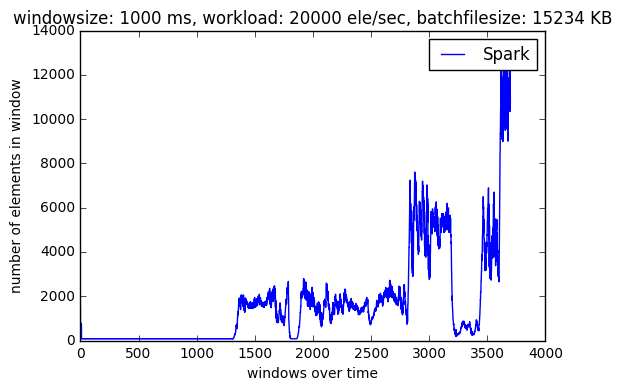

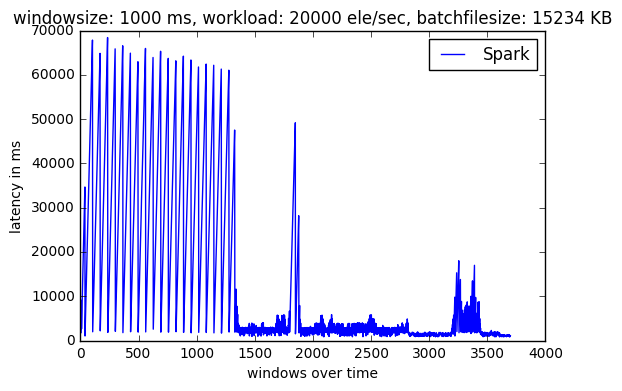

32383.194
results-examples\130-20-3min.csv


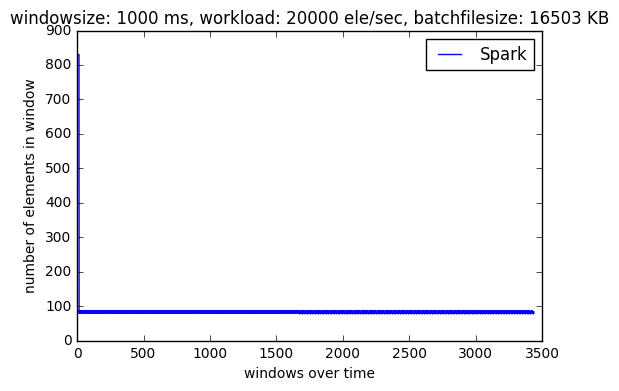

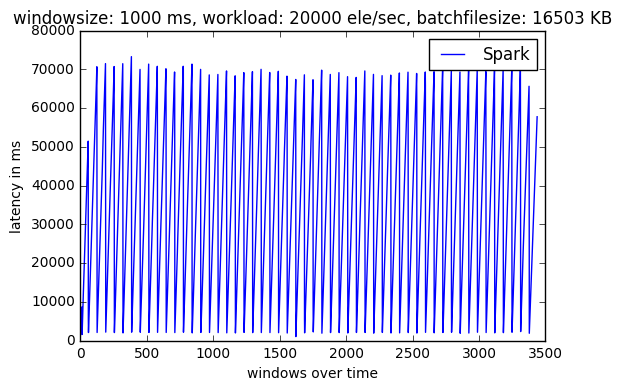

35978.022
results-examples\2h-3min.csv


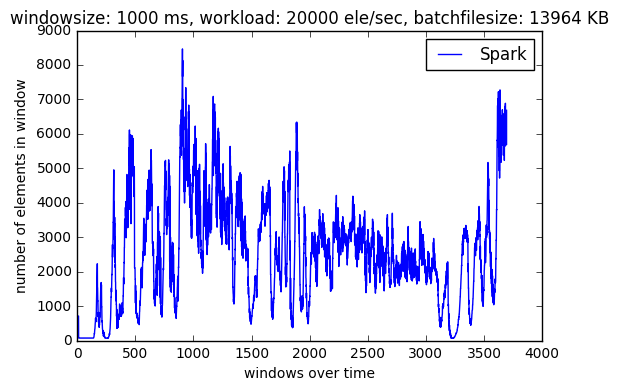

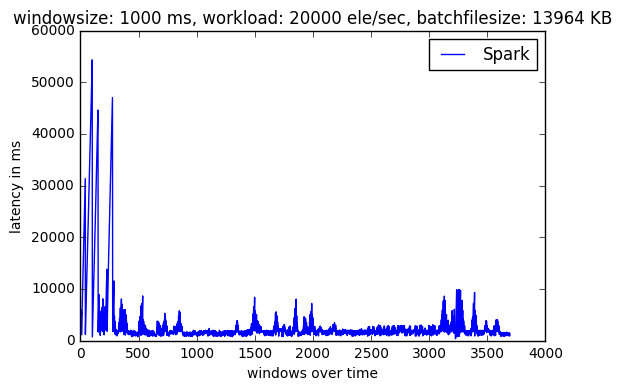

1954.756
results-examples\3000sall3min.csv


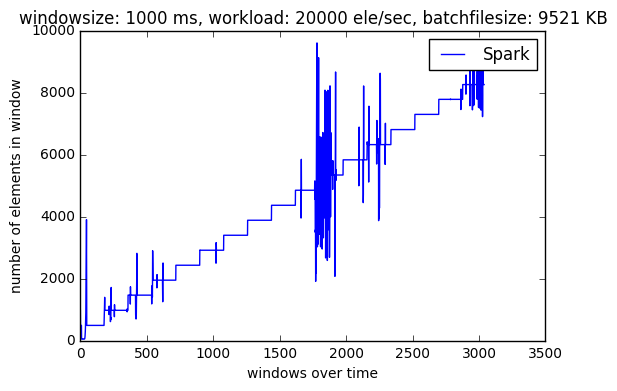

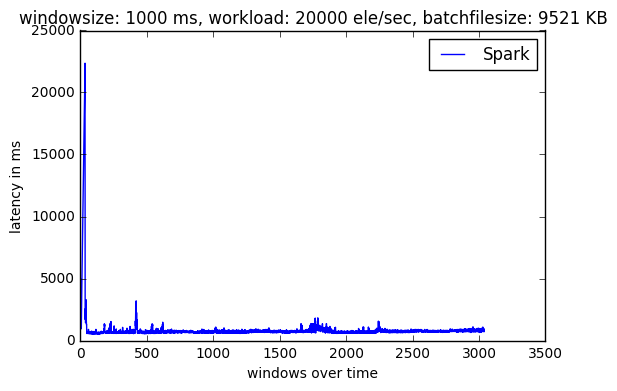

693.552
results-examples\3min,2h,20.csv


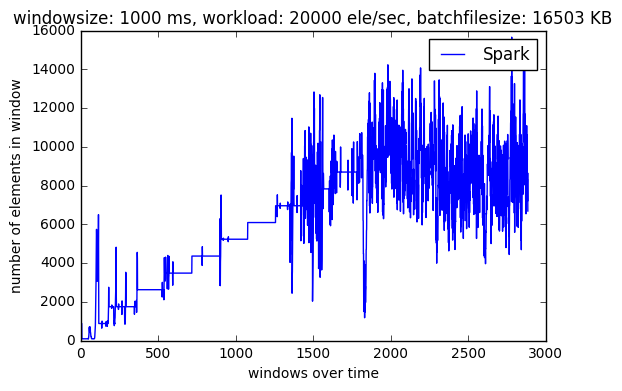

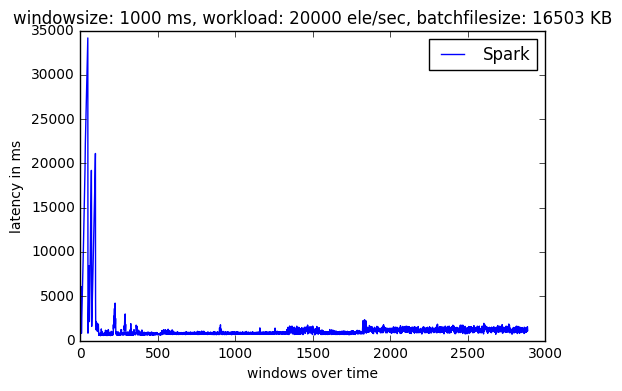

810.168
results-examples\old.csv


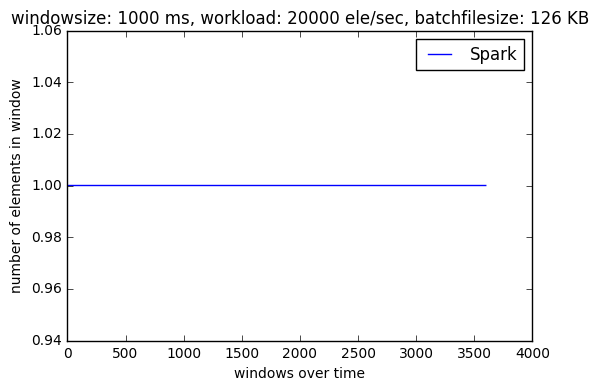

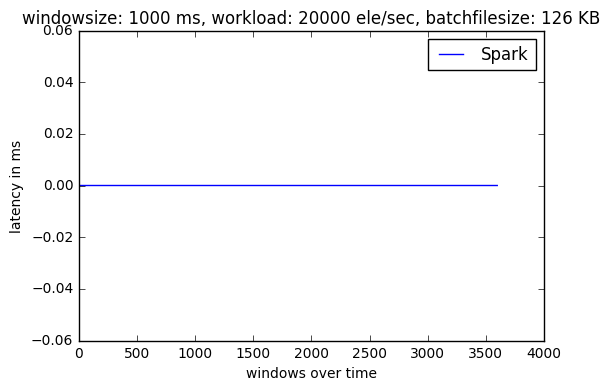

0.0
results-examples\partialfile_1000-1489098782000-partial.csv


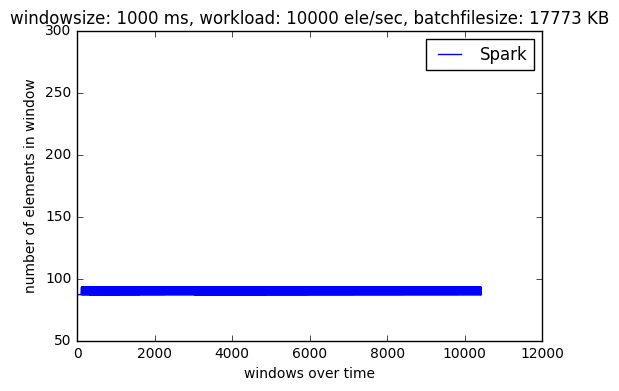

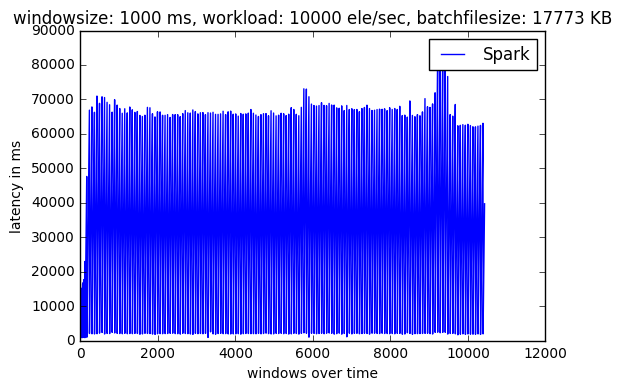

35321.166
results-examples\partialfile_1000-1489103593000.csv


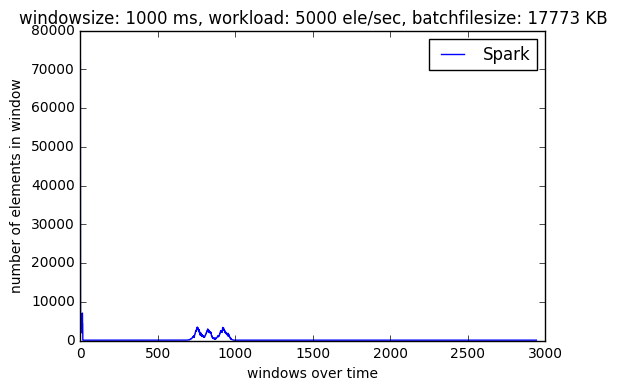

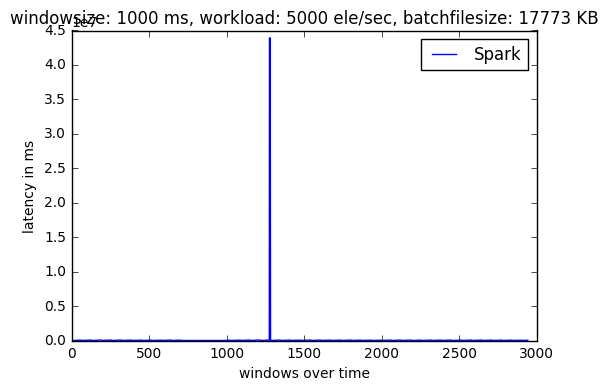

16023.396
results-examples\partialfile_1000-1489162105000.csv


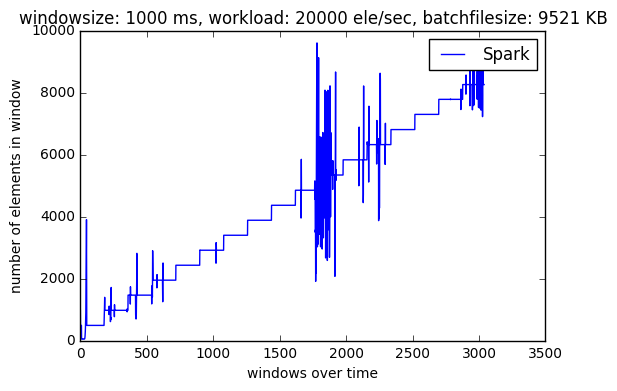

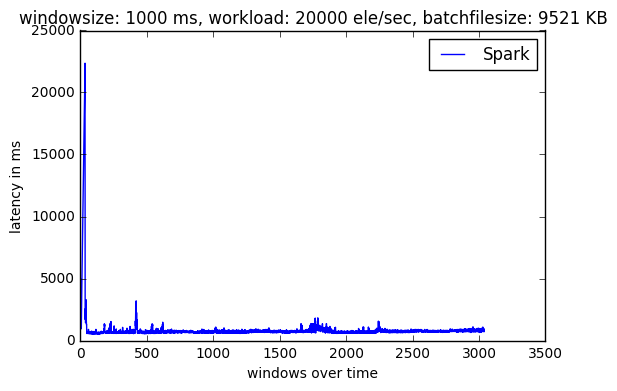

693.552
results-examples\partialfile_1000-1489250510000.csv


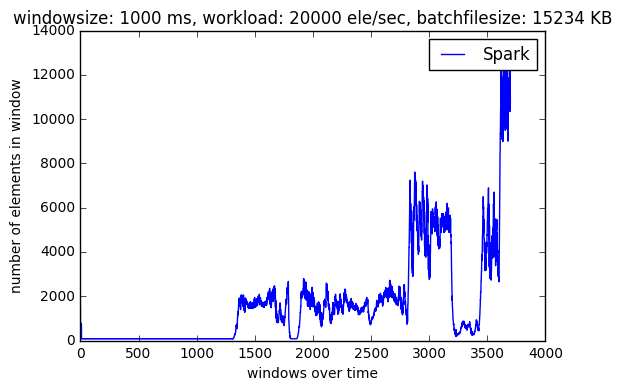

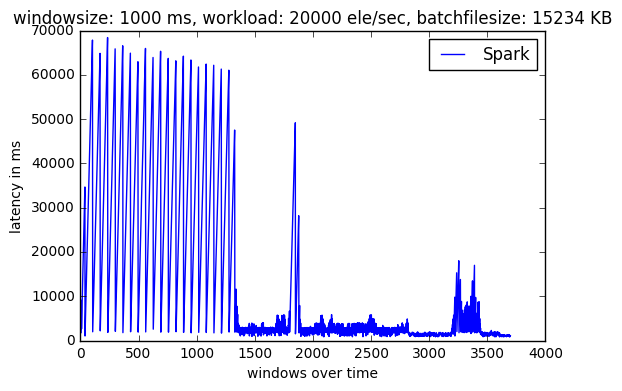

32383.194
results-examples\partialfile_1000-1489421034000.csv


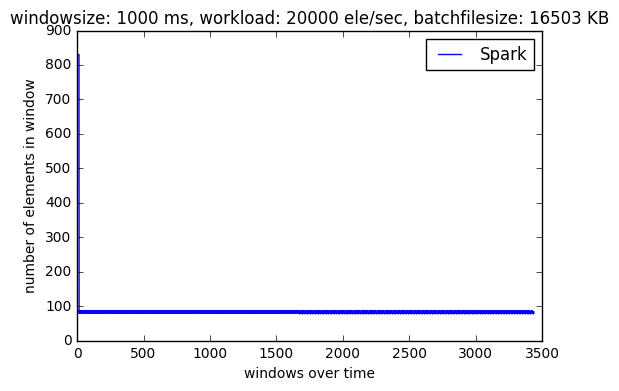

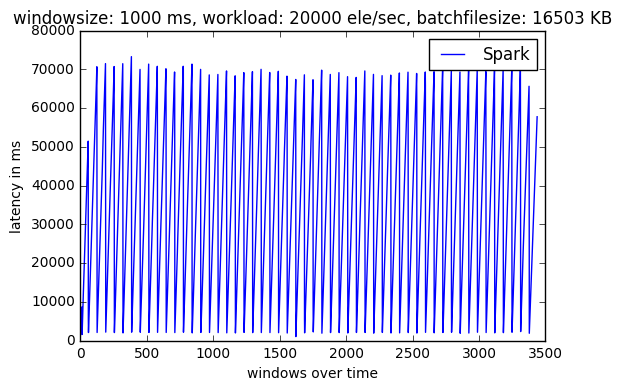

35978.022


In [101]:
#show number of elements to illustrate backpressuring

#import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import numpy as np
number = 1
%matplotlib inline
for file in glob.glob("results-examples\*"):
    print(file)
    r= read_csv(file,names = ["system","windowsize","batchfilesize", "workload","latency","th"
                              ,"numberelements"])    
    #lim=250
    y=r["numberelements"].values/6
    
    x=np.arange(0,len(y))
    #plt.scatter( x , y ,color="Blue",s=1,label="Spark")
    
    #if(number==1):
    plt.plot(x,y,color="Blue",label="Spark")
    #if(number==2):
    #    plt.plot(x,y,color="Red",label="Flink")
    titlestring="windowsize: %s ms, workload: %s ele/sec, batchfilesize: %s KB" %(
        r["windowsize"].values[0],r["workload"].values[0],r["batchfilesize"].values[0]*130/1024)
    plt.title(titlestring)
    plt.xlabel("windows over time")
    plt.ylabel("number of elements in window")
    plt.legend()
    #plt.ylim([0,450000])
    path='graphs/%selementsOverTime.png' %(number)
    number=number+1
    #savefig(path)
    plt.show()
    plt.plot(x,r["latency"].values,color="Blue",label="Spark")
    plt.title(titlestring)
    plt.legend()
    plt.xlabel("windows over time")
    plt.ylabel("latency in ms")
    path='graphs/%selementsOverTime.png' %(number)
    #savefig(path)
    plt.show()
    print(r["latency"].values[500:1000].mean())


#for file in glob.glob("results-examples\*"):
 #   r= read_csv(file,names = ["system","windowsize","batchfilesize", "workload","latency","th"
    #                          ,"numberelements"])  
    #if(number==3):
   # plt.plot(x,r["latency"].values,color="Blue",label="Spark")
    #if(number==4):
        #plt.plot(x,r["latency"].values[0:lim],color="Red",label="Flink")
    #plt.plot(x,r["Latency"].values[0:lim],color="Red")
    #plt.title("Latency over time for Flink")
    #plt.ylim([0,650])
    #plt.xlabel("elements over time")
    #plt.ylabel("latency in ms")
    #plt.title(titlestring)
    #plt.legend()
    #path='graphs/%latencyoverTime.png' %(number)
    #number=number+1
    #plt.show()
#savefig(path) 


results-examples\10000-180.csv


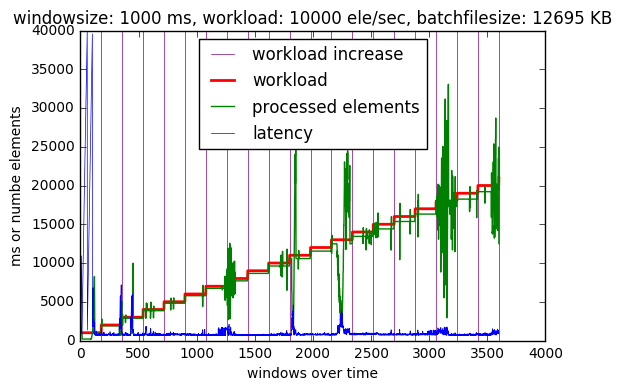

results-examples\120-20-3min.csv


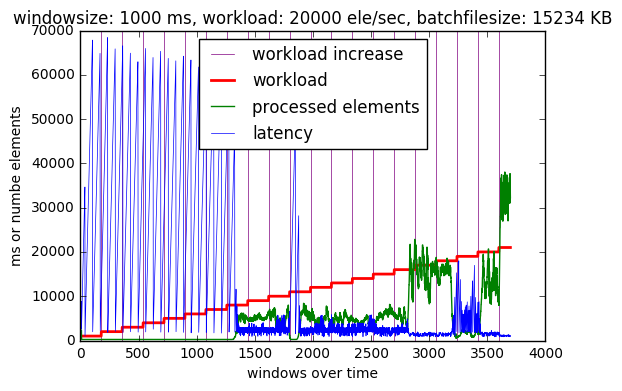

results-examples\130-20-3min.csv


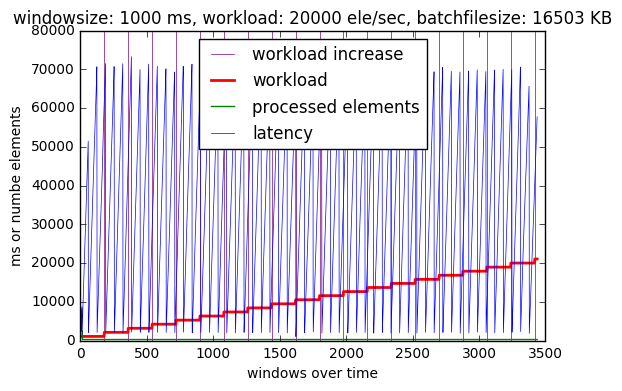

results-examples\2h-3min.csv


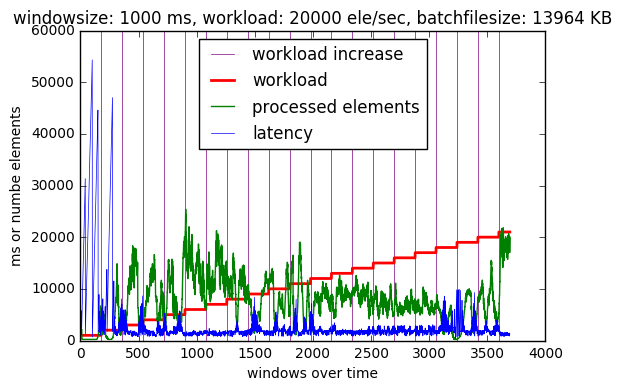

results-examples\3000sall3min.csv


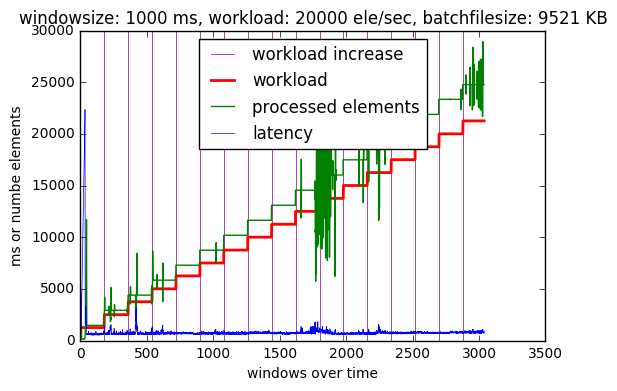

results-examples\3min,2h,20.csv


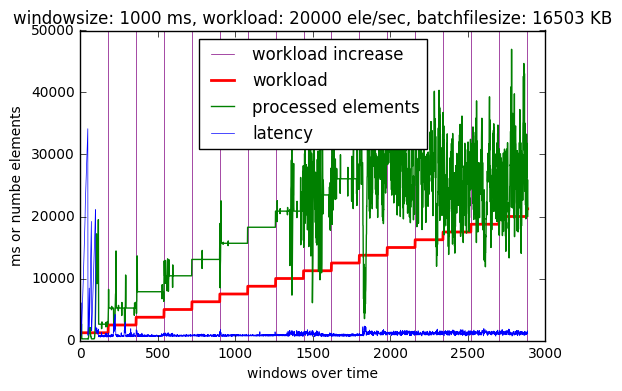

results-examples\old.csv


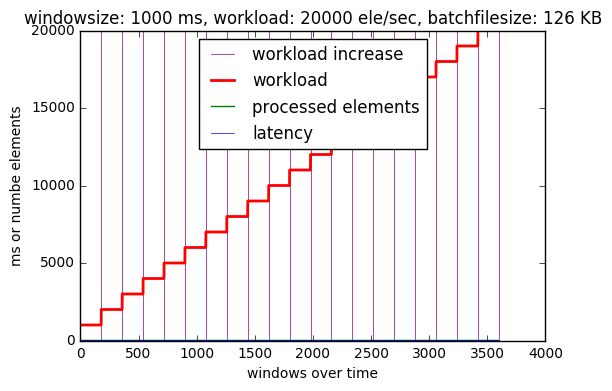

results-examples\partialfile_1000-1489103593000.csv


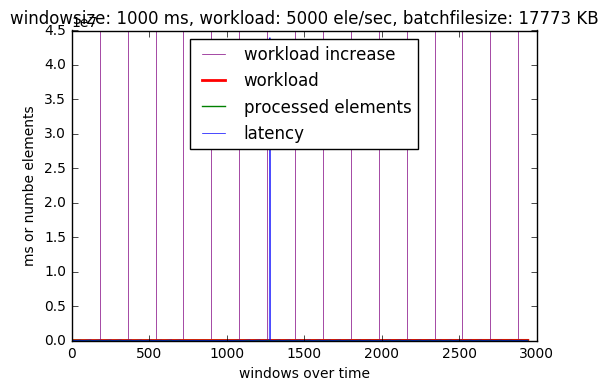

In [98]:
#show number of elements to illustrate backpressuring

#import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import numpy as np
number = 1
%matplotlib inline
for file in glob.glob("results-examples\*"):
    print(file)
    r= read_csv(file,names = ["system","windowsize","batchfilesize", "workload","latency","th"
                              ,"numberelements"])    
    #lim=250
    y=r["numberelements"].values/2
    
    x=np.arange(0,len(y))
    #plt.scatter( x , y ,color="Blue",s=1,label="Spark")
    
    
    
    #max latencies
    intervallsize=180
    maxlat=20000
    size=len(y)
    numLoops=size/intervallsize
    start=maxlat/numLoops
    maxRate=np.arange(0,size)
    for i in range(0,size):
        maxRate[i]=start*(i/intervallsize+1)
    
    
    #vertical line
    plt.axvline(0,color="Purple",linewidth=0.5,label="workload increase")
    for i in range(1,numLoops+1):
        plt.axvline(intervallsize*i,color="Purple",linewidth=0.5)
    
    plt.plot(x,maxRate,color="Red",label="workload",linewidth=2)
    #if(number==1):
    plt.plot(x,y,color="Green",label="processed elements")
    #if(number==2):
    #    plt.plot(x,y,color="Red",label="Flink")
    titlestring="windowsize: %s ms, workload: %s ele/sec, batchfilesize: %s KB" %(
        r["windowsize"].values[0],r["workload"].values[0],r["batchfilesize"].values[0]*130/1024)
    plt.title(titlestring)
    plt.xlabel("windows over time")
    plt.ylabel("number of elements in window")
    
    
    
    
    path='graphs/%selementsOverTime.png' %(number)
    number=number+1
    savefig(path)
    #plt.show()
    plt.plot(x,r["latency"].values,color="Blue",label="latency",linewidth=0.5)
    plt.title(titlestring)
    
    plt.xlabel("windows over time")
    plt.ylabel("ms or numbe elements")
    path='graphs/%selementsOverTime.png' %(number)
    
    plt.legend(loc='upper center')
    #plt.ylim([0,25000])
    #plt.xlim([0,5000])
    
    #savefig(path)
    plt.show()
    #print(r["latency"].values[500:1000].mean())


#for file in glob.glob("results-examples\*"):
 #   r= read_csv(file,names = ["system","windowsize","batchfilesize", "workload","latency","th"
    #                          ,"numberelements"])  
    #if(number==3):
   # plt.plot(x,r["latency"].values,color="Blue",label="Spark")
    #if(number==4):
        #plt.plot(x,r["latency"].values[0:lim],color="Red",label="Flink")
    #plt.plot(x,r["Latency"].values[0:lim],color="Red")
    #plt.title("Latency over time for Flink")
    #plt.ylim([0,650])
    #plt.xlabel("elements over time")
    #plt.ylabel("latency in ms")
    #plt.title(titlestring)
    #plt.legend()
    #path='graphs/%latencyoverTime.png' %(number)
    #number=number+1
    #plt.show()
#savefig(path) 


In [117]:
#show number of elements to illustrate backpressuring

#import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import numpy as np
number = 1
%matplotlib inline

def plotRuntime(file,intervallsize,maxlat,save):
    print(file)
    r= read_csv(file,names = ["system","windowsize","batchfilesize", "workload","latency","th"
                              ,"numberelements"])    
    #lim=250
    y=r["numberelements"].values/2
    
    x=np.arange(0,len(y))
    #plt.scatter( x , y ,color="Blue",s=1,label="Spark")
    
    
    
    #max latencies
    #intervallsize=180
    #maxlat=12500
    size=len(y)
    numLoops=size/intervallsize
    start=maxlat/numLoops
    maxRate=np.arange(0,size)
    for i in range(0,size):
        maxRate[i]=start*(i/intervallsize+1)
    
    
    #vertical line
    plt.axvline(0,color="Purple",linewidth=0.5,label="workload increase")
    for i in range(1,numLoops+1):
        plt.axvline(intervallsize*i,color="Purple",linewidth=0.5)
    
    plt.plot(x,maxRate,color="Red",label="workload",linewidth=2)
    #if(number==1):
    plt.plot(x,y,color="Green",label="processed elements")
    #if(number==2):
    #    plt.plot(x,y,color="Red",label="Flink")
    titlestring="windowsize: %s ms, workload: %s ele/sec, batchfilesize: %s KB" %(
        r["windowsize"].values[0],r["workload"].values[0],r["batchfilesize"].values[0]*130/1024)
    plt.title(titlestring)
    plt.xlabel("windows over time")
    plt.ylabel("number of elements in window")
    
    
    #plt.show()
    plt.plot(x,r["latency"].values,color="Blue",label="latency",linewidth=0.5)
    plt.title(titlestring)
    plt.ylim([0,50000])
    plt.xlabel("windows over time")
    plt.ylabel("ms or numbe elements")
    path='graphs/%-runtime.png' %(file)
    print(path)
    path="graphs/1.png"
    plt.legend(loc='upper center')
    
    if(save):
        savefig(path)
    plt.show()



<open file 'results-examples/10000-180.csv', mode 'r' at 0x000000000B6CE6F0>
graphs/<open file 'results-examples/10000-180.csv', mode 'r' at 0x000000000B6CE6F0>untime.png


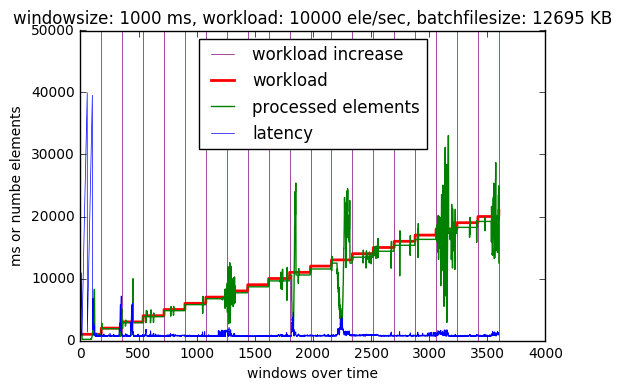

In [118]:
#plotRuntime(open("results-examples/2h-3min.csv"),180,20000,False)
plotRuntime(open("results-examples/10000-180.csv"),180,20000,True)
#plotRuntime(open("results-examples/3min,2h,20.csv"),180,40000,True)

#plotRuntime(open("results-examples/old.csv"),180,20000,False)